In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
!pip install XGBOOST
import xgboost as xgb

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Quora_question_pair_data/ML_modelling_data.csv')

In [4]:
 df.head()

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,q1_n_words,q2_n_words,word_common,...,290.1,291.1,292.1,293.1,294.1,295.1,296.1,297.1,298.1,299.1
0,0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,14.0,12.0,11.0,...,90.842673,-109.121875,-103.461947,93.912287,24.555147,-13.950214,-14.532000,-128.323186,-125.105671,87.540304
1,1,1,3,4,what is the story of kohinoor kohinoor diamond,what would happen if the indian government sto...,0,8.0,13.0,4.0,...,60.318785,36.759359,89.701675,68.875638,-87.536221,31.325016,-88.937340,66.108022,-117.743915,61.278787
2,2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,14.0,10.0,4.0,...,73.656094,-4.256963,172.464854,1.855481,-85.113197,64.203202,146.907226,-253.900569,-170.002529,168.029946
3,3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math2324math is divide...,0,11.0,9.0,0.0,...,77.860768,-71.490774,-25.844452,-7.730651,-86.217268,67.093756,-45.410198,-158.506922,-10.452024,61.258758
4,4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt wat,0,13.0,7.0,4.0,...,109.881261,-19.280973,109.475905,1.795609,-88.208753,33.786041,58.574612,-33.243239,-53.404904,3.535569


In [5]:
df.shape

(402572, 635)

In [6]:
first_34_columns = df.columns[:40].tolist()
first_34_columns

['Unnamed: 0',
 'id',
 'qid1',
 'qid2',
 'question1',
 'question2',
 'is_duplicate',
 'q1_n_words',
 'q2_n_words',
 'word_common',
 'word_total',
 'q1len',
 'q2len',
 'word_share',
 'freq_qid1',
 'freq_qid2',
 'freq_q1+freq_q2',
 'freq_q1-freq_q2',
 'fuzzy_ratio',
 'fuzzy_partial_ratio',
 'token_sort_ratio',
 'token_set_ratio',
 'common_word_count',
 'common_stop_count',
 'common_token_count',
 'cwc_min',
 'cwc_max',
 'csc_min',
 'csc_max',
 'ctc_min',
 'ctc_max',
 'first_word_eq',
 'last_word_eq',
 'abs_len_diff',
 'mean_len',
 '0',
 '1',
 '2',
 '3',
 '4']

In [8]:
df_model = df.sample(n=100000)
print("Original shape of the data : ", df_model.shape)
data = df_model.copy()

y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','question1', 'question2',
       'is_duplicate','common_word_count','common_stop_count','common_token_count','qid1',
 'qid2'], axis=1, inplace=True)

print("Original shape of the data : ", data.shape)

Original shape of the data :  (100000, 635)
Original shape of the data :  (100000, 625)


In [9]:
data = data.apply(pd.to_numeric)

In [10]:
y_true = list(map(int, y_true.values))

# **Random Train Test Split (70:30)**

In [11]:
x_train, x_test, y_train, y_test = train_test_split(data, y_true, test_size=0.3, random_state=42)

In [12]:
print(x_train.shape)
print(x_test.shape)

(70000, 625)
(30000, 625)


In [13]:
from typing import Counter
# Distribution of train and test data
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0:" , int(train_distr[0])/train_len, "Class 1:" , int(train_distr[1])/train_len)

test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0:" , int(test_distr[0])/test_len, "Class 1:" , int(test_distr[1])/test_len)

Class 0: 0.6293714285714286 Class 1: 0.3706285714285714
Class 0: 0.6256 Class 1: 0.3744


In [14]:
def plot_confusion_matrix(y_test, y_pred):
  C = confusion_matrix(y_test, y_pred)


  A = (((C.T)/(np.cumsum(C, axis = 1))).T)
  B = (C/C.sum(axis=0))

  plt.figure(figsize=(20,7))

  labels = [0,1]

  cmap = sns.light_palette("blue")
  plt.subplot(1,3,1)

  sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel("Predict Class")
  plt.ylabel("original Class")
  plt.title("Confusion Matrix")


  plt.subplot(1,3,2)
  sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel("Predict Class")
  plt.ylabel("original Class")
  plt.title("precision Matrix")


  plt.subplot(1,3,3)
  sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel("Predict Class")
  plt.ylabel("original Class")
  plt.title("Recal Matrix")

  plt.show()

# **Build a random model (Finding the worst case logloss)**

log loss on test Data using Random Model 0.8921308856704704


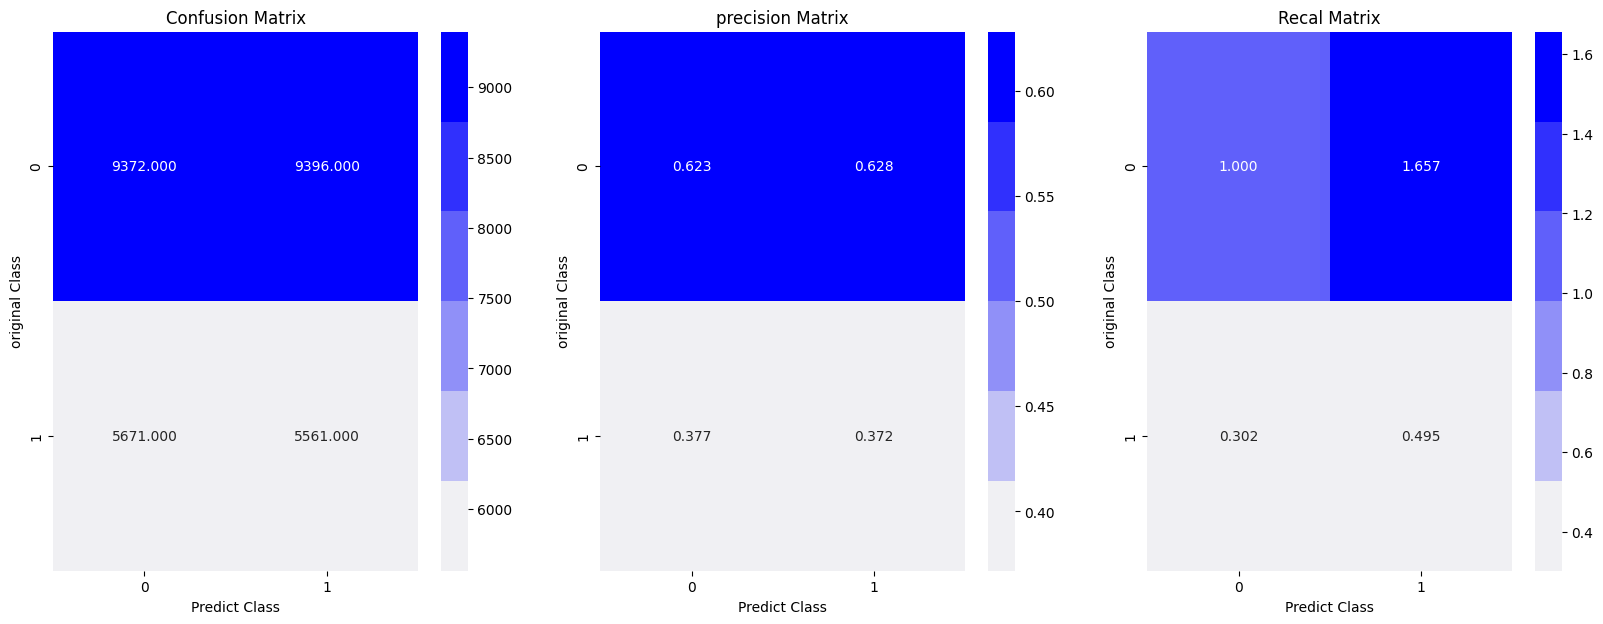

In [15]:
predicted_y = np.zeros((test_len, 2))
for i in range(test_len):
  rand_probs = np.random.rand(1,2)
  predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("log loss on test Data using Random Model", log_loss(y_test, predicted_y))

predicted_y = np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

# **Logistic Regression with hyperparameter tunning**
 Why logistic Reg = we have fairly large dimensional data (625)
 so it works well for this data

for values of alpha =  1e-05 the log loss is : 0.4407199638624837
for values of alpha =  0.0001 the log loss is : 0.44246478068698875
for values of alpha =  0.001 the log loss is : 0.4413317394295089
for values of alpha =  0.01 the log loss is : 0.4525358948507314
for values of alpha =  0.1 the log loss is : 0.4319504500400696
for values of alpha =  1 the log loss is : 0.4523082174246276
for values of alpha =  10 the log loss is : 0.4934329899349421


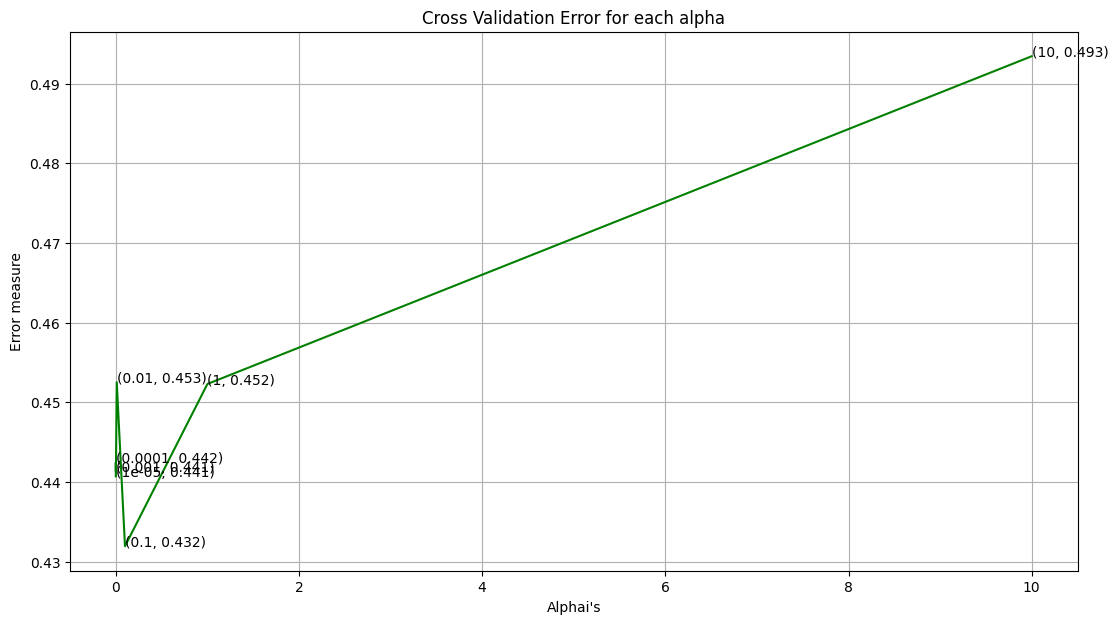

for Values of best alpha = 0.1 the train log loss is : 0.42539703467248063
Total no. of data points: 70000


ValueError: Found input variables with inconsistent numbers of samples: [30000, 70000]

In [16]:
alpha = [10 ** x for x in range(-5,2)]


log_error_array=[]
for i in alpha:
  clf = SGDClassifier(alpha=i, penalty= 'l2', loss='log_loss', random_state=42)
  clf.fit(x_train, y_train)
  sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
  sig_clf.fit(x_train, y_train)
  predict_y = sig_clf.predict_proba(x_test)
  log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_))
  print("for values of alpha = ",i, "the log loss is :", log_loss(y_test, predict_y ))


fig, ax = plt.subplots()
fig.set_size_inches(13, 7)
ax.plot(alpha, log_error_array, c= 'g')
for i, txt in enumerate(np.round(log_error_array,3)):
  ax.annotate((alpha[i], np.round(txt,3)), (alpha[i], log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alphai's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha = alpha[best_alpha] , penalty= 'l2', loss='log_loss', random_state=42)
clf.fit(x_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train)

for Values of best alpha = 0.1 the train log loss is : 0.42539703467248063
Total no. of data points: 70000


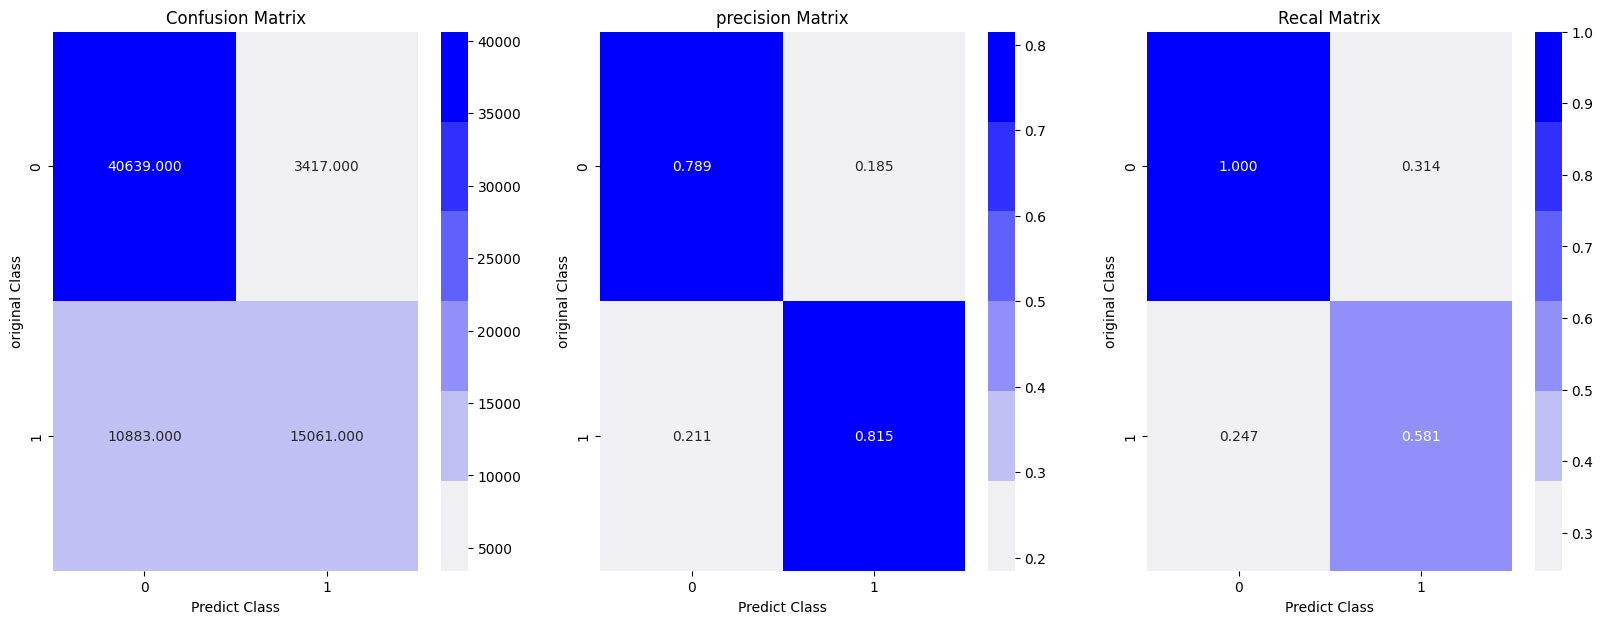

for Values of best alpha = 0.1 the test log loss is : 0.4319504500400696
Total no. of data points: 30000


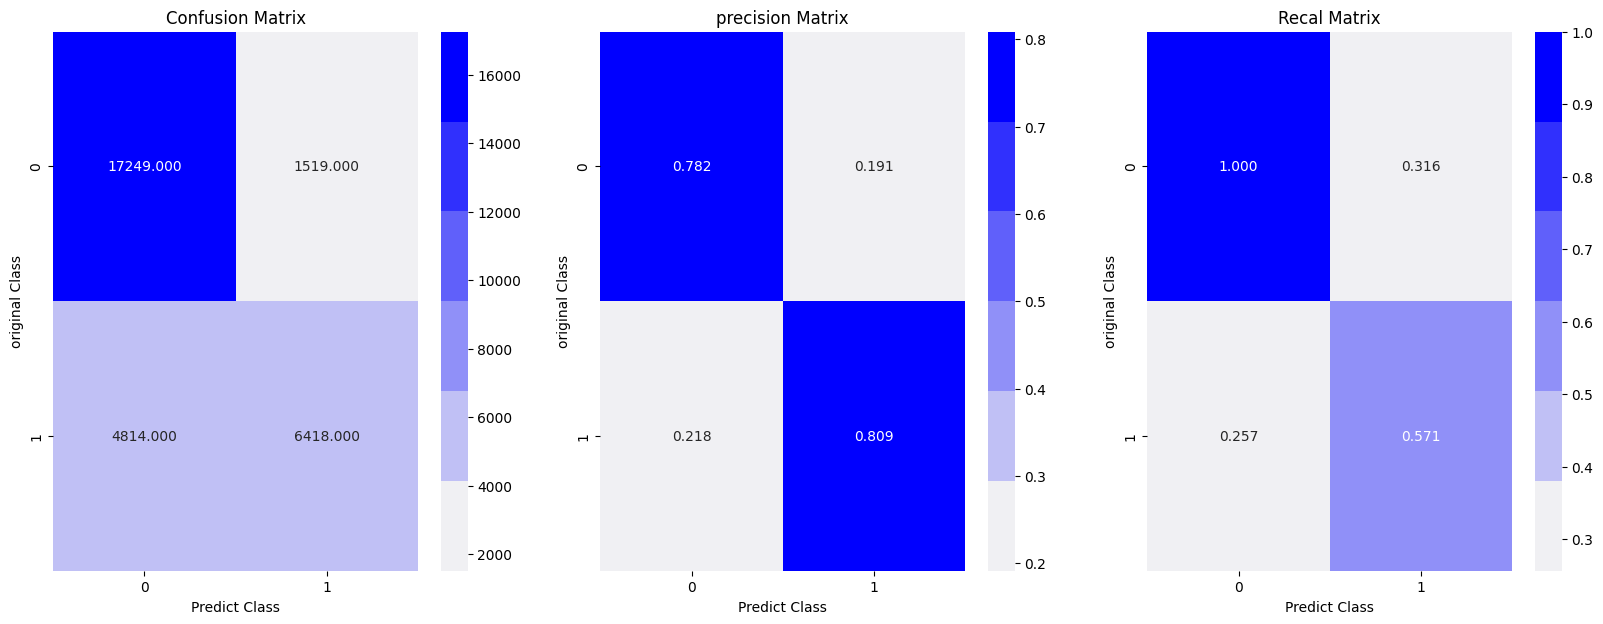

In [18]:
predict_y = sig_clf.predict_proba(x_train)
print("for Values of best alpha =", alpha[best_alpha], "the train log loss is :", log_loss(y_train, predict_y))
print("Total no. of data points:", len(predict_y))
predict_y = np.argmax(predict_y, axis=1)
plot_confusion_matrix(y_train, predict_y)

predict_y = sig_clf.predict_proba(x_test)
print("for Values of best alpha =", alpha[best_alpha], "the test log loss is :", log_loss(y_test, predict_y))
predict_y = np.argmax(predict_y, axis=1)
print("Total no. of data points:", len(predict_y))
plot_confusion_matrix(y_test, predict_y)

# **Linear SVM with Hyperparameter tunning**

for values of alpha =  1e-05 the log loss is : 0.434407441420307
for values of alpha =  0.0001 the log loss is : 0.432219084938823
for values of alpha =  0.001 the log loss is : 0.43556919843251213
for values of alpha =  0.01 the log loss is : 0.5425490487650648
for values of alpha =  0.1 the log loss is : 0.5962325264235696
for values of alpha =  1 the log loss is : 0.6324940658300228
for values of alpha =  10 the log loss is : 0.656397436461847


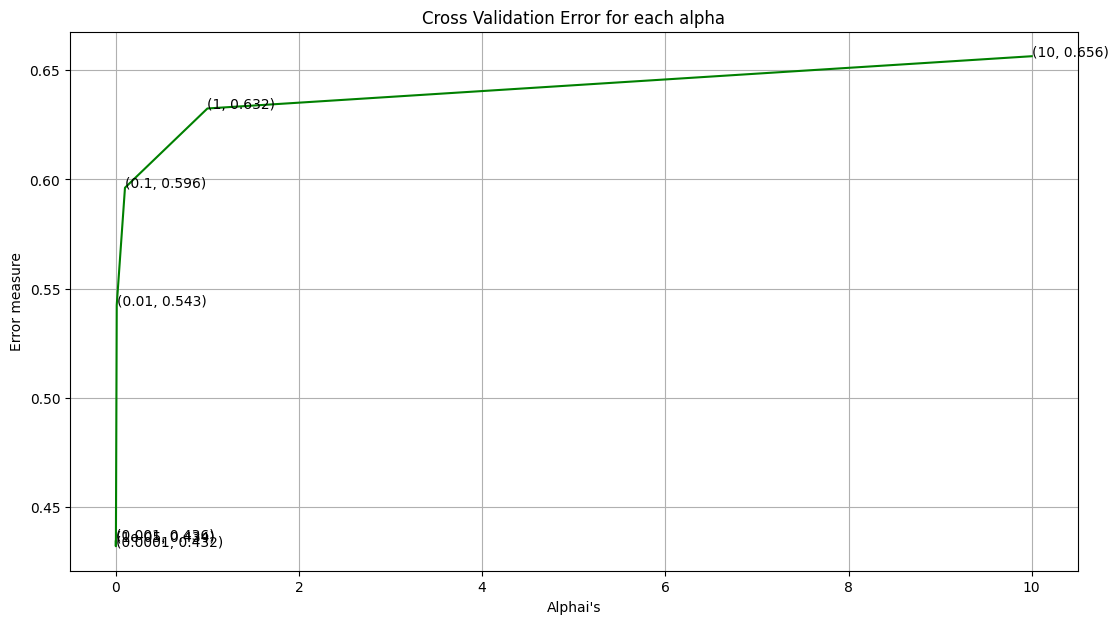

for Values of best alpha = 0.0001 the train log loss is : 0.4253160146525206
Total no. of data points: 70000


ValueError: Found input variables with inconsistent numbers of samples: [30000, 70000]

In [19]:
alpha = [10 ** x for x in range(-5,2)]


log_error_array=[]
for i in alpha:
  clf = SGDClassifier(alpha=i, penalty= 'l1', loss='hinge', random_state=42)
  clf.fit(x_train, y_train)
  sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
  sig_clf.fit(x_train, y_train)
  predict_y = sig_clf.predict_proba(x_test)
  log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_))
  print("for values of alpha = ",i, "the log loss is :", log_loss(y_test, predict_y ))


fig, ax = plt.subplots()
fig.set_size_inches(13, 7)
ax.plot(alpha, log_error_array, c= 'g')
for i, txt in enumerate(np.round(log_error_array,3)):
  ax.annotate((alpha[i], np.round(txt,3)), (alpha[i], log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alphai's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty= 'l1', loss='hinge', random_state=42)
clf.fit(x_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train)


predict_y = sig_clf.predict_proba(x_train)
print("for Values of best alpha =", alpha[best_alpha], "the train log loss is :", log_loss(y_train, predict_y))
print("Total no. of data points:", len(predict_y))
predict_y = np.argmax(predict_y, axis=1)
plot_confusion_matrix(y_train, predict_y)

predict_y = sig_clf.predict_proba(x_test)
print("for Values of best alpha =", alpha[best_alpha], "the test log loss is :", log_loss(y_test, predict_y))
predict_y = np.argmax(predict_y, axis=1)
print("Total no. of data points:", len(predict_y))
plot_confusion_matrix(y_test, predict_y)

for Values of best alpha = 0.0001 the train log loss is : 0.4253160146525206
Total no. of data points: 70000


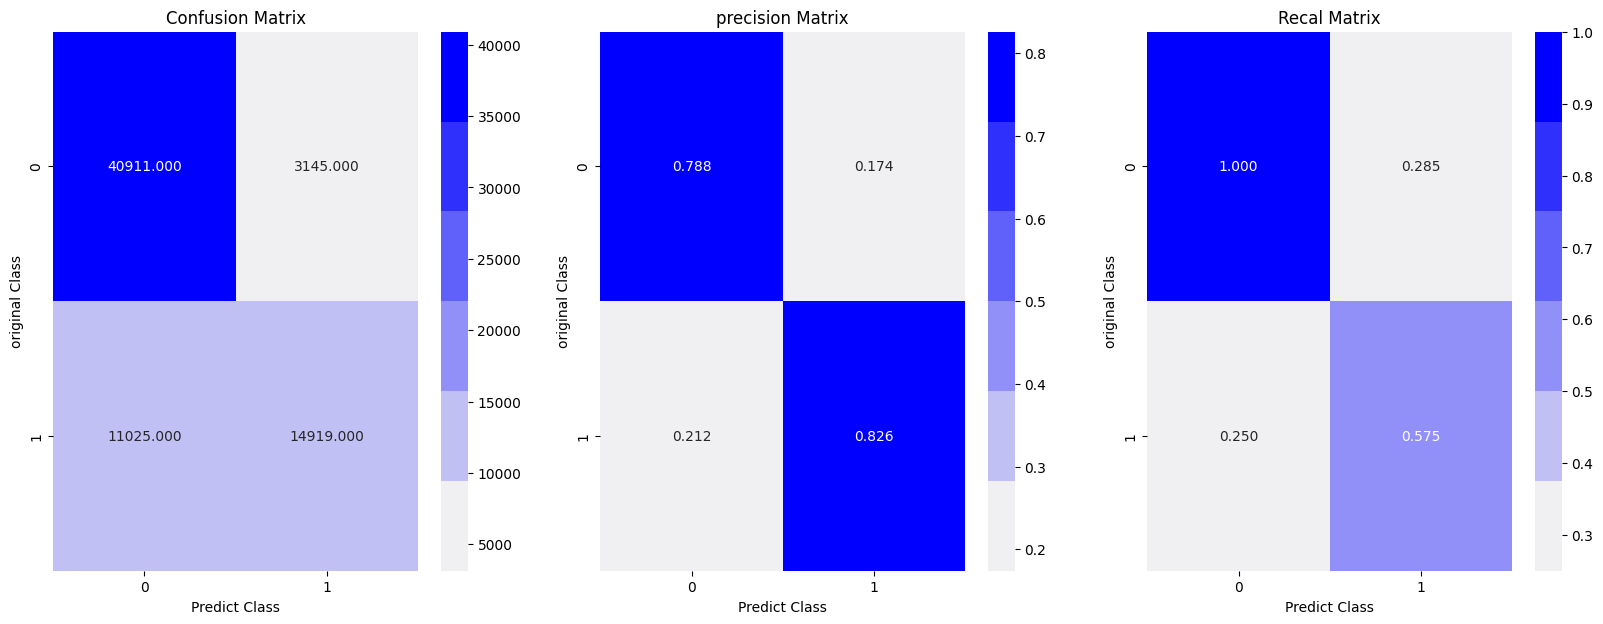

for Values of best alpha = 0.0001 the test log loss is : 0.432219084938823
Total no. of data points: 30000


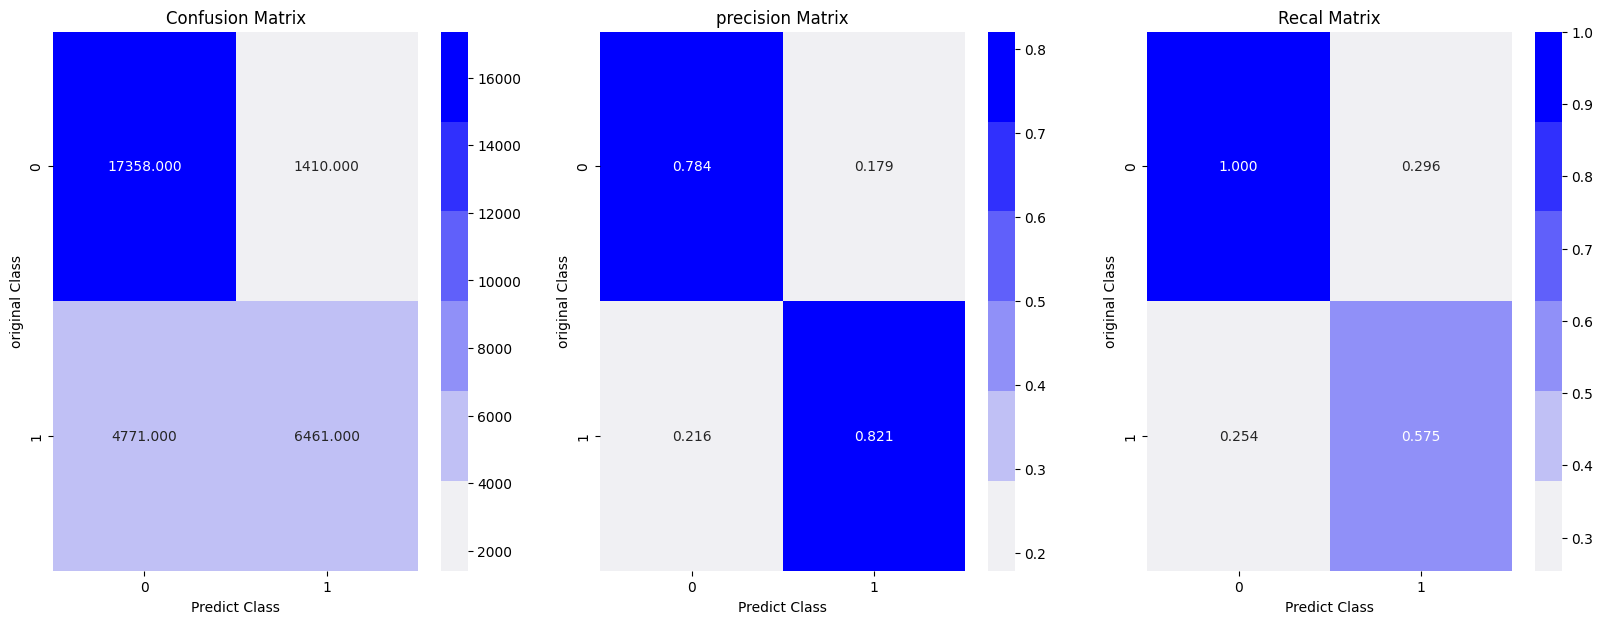

In [20]:
predict_y = sig_clf.predict_proba(x_train)
print("for Values of best alpha =", alpha[best_alpha], "the train log loss is :", log_loss(y_train, predict_y))
print("Total no. of data points:", len(predict_y))
predict_y = np.argmax(predict_y, axis=1)
plot_confusion_matrix(y_train, predict_y)

predict_y = sig_clf.predict_proba(x_test)
print("for Values of best alpha =", alpha[best_alpha], "the test log loss is :", log_loss(y_test, predict_y))
predict_y = np.argmax(predict_y, axis=1)
print("Total no. of data points:", len(predict_y))
plot_confusion_matrix(y_test, predict_y)

# **GBDT using XGBOOST Implementation**

[0]	train-logloss:0.65076	test-logloss:0.65271
[10]	train-logloss:0.58158	test-logloss:0.58346
[20]	train-logloss:0.53227	test-logloss:0.53396
[30]	train-logloss:0.49549	test-logloss:0.49707
[40]	train-logloss:0.46710	test-logloss:0.46841
[50]	train-logloss:0.44576	test-logloss:0.44689
[60]	train-logloss:0.42906	test-logloss:0.43015
[70]	train-logloss:0.41514	test-logloss:0.41613
[80]	train-logloss:0.40387	test-logloss:0.40482
[90]	train-logloss:0.39477	test-logloss:0.39578
[100]	train-logloss:0.38715	test-logloss:0.38826
[110]	train-logloss:0.38064	test-logloss:0.38193
[120]	train-logloss:0.37498	test-logloss:0.37646
[130]	train-logloss:0.37007	test-logloss:0.37176
[140]	train-logloss:0.36609	test-logloss:0.36797
[150]	train-logloss:0.36219	test-logloss:0.36426
[160]	train-logloss:0.35913	test-logloss:0.36147
[170]	train-logloss:0.35622	test-logloss:0.35883
[180]	train-logloss:0.35362	test-logloss:0.35662
[190]	train-logloss:0.35123	test-logloss:0.35457
[200]	train-logloss:0.34891	tes

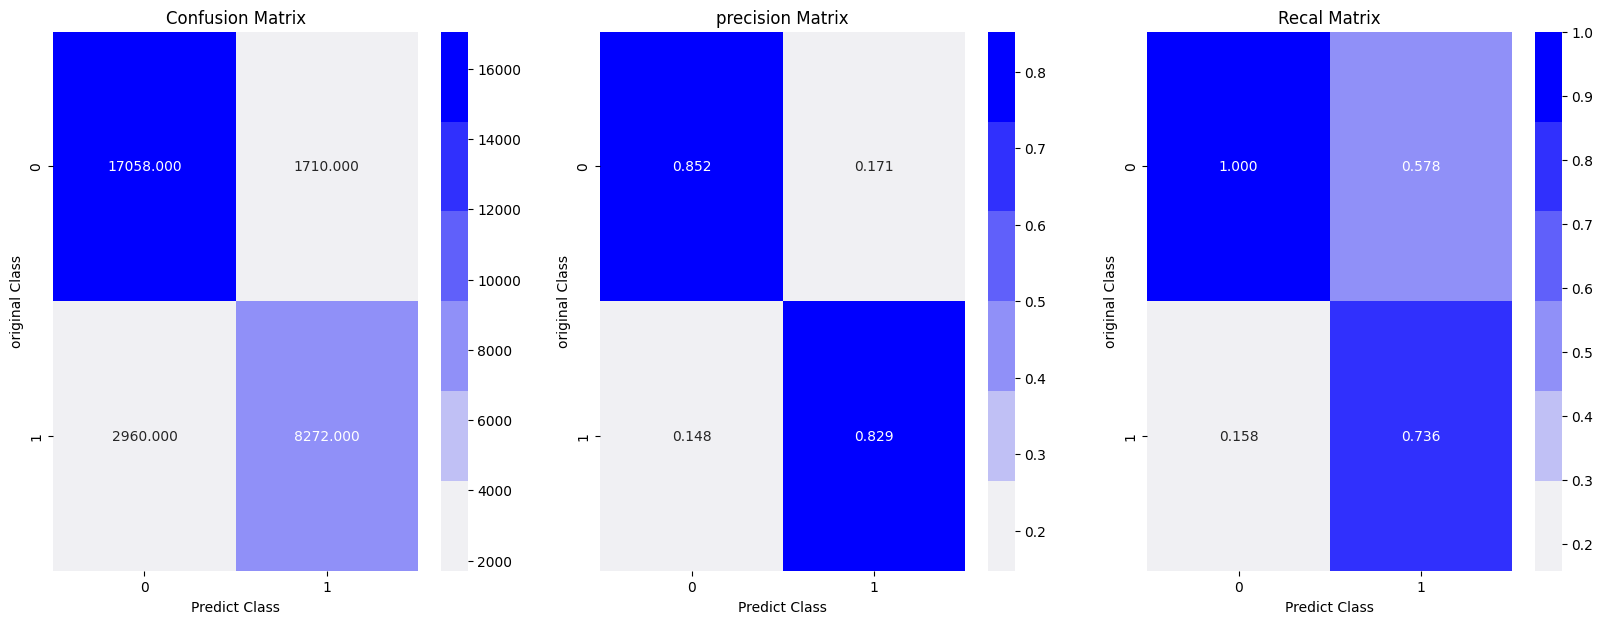

In [21]:
param = {}
param['objective'] = 'binary:logistic'
param['eval_metric'] = 'logloss'
param['eta'] = 0.02
param['max_depth'] = 4



d_train = xgb.DMatrix(x_train, label=y_train)
d_test = xgb.DMatrix(x_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'test')]

bst = xgb.train(param, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(x_train, y_train)
predict_y = bst.predict(d_test)
print("the test log loss is : " , log_loss(y_test, predict_y, labels=[0, 1]))

predicted_y = np.array(predict_y>0.5, dtype = int)
print("total no. of predicted points : ", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)